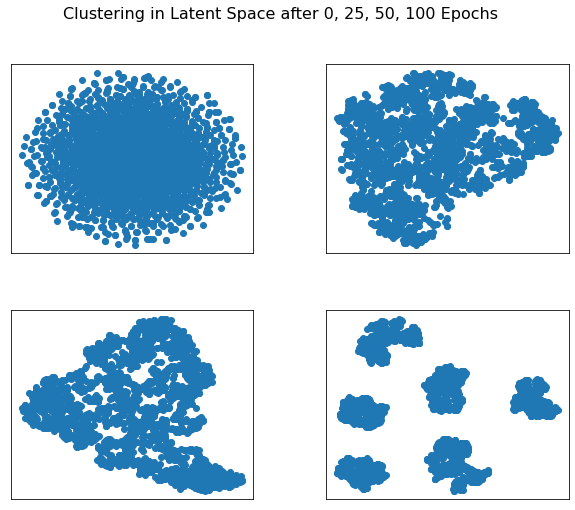

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
tsne_0 = np.load('./TSNE_images/0.npy')
tsne_5 = np.load('./TSNE_images/5.npy')
tsne_10 = np.load('./TSNE_images/10.npy')
tsne_final = np.load('./TSNE_images/final.npy')

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0,0].scatter(tsne_0[:,0], tsne_0[:,1])
axs[0,1].scatter(tsne_5[:,0], tsne_5[:,1])
axs[1,0].scatter(tsne_10[:,0], tsne_10[:,1])
axs[1,1].scatter(tsne_final[:,0], tsne_final[:,1])

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Clustering in Latent Space after 0, 25, 50, 100 Epochs', fontsize=16)

plt.subplots_adjust(hspace=0.3, wspace=0.3)


In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader

from ae.vae_trainer import VAETrainer
#from ae.cvae_glau import CVAE
#from ae.cvae_cifar import CVAE
#from ae.cvae import CVAE
from ae.cvae_mnist import CVAE
from ae.vae import VAE
from torch.utils.data import Dataset


class IDEC(nn.Module):

    def __init__(self,
                 n_input,
                 n_z,
                 n_clusters,
                 alpha=1,
                 pretrain_path='saved_models/VAE/cvae_cifar10.pkl'):
        super(IDEC, self).__init__()
        self.alpha = 1.0
        self.pretrain_path = pretrain_path

        self.ae = CVAE(in_shape=n_input, n_z=n_z)
        # cluster layer
        self.cluster_layer = Parameter(torch.Tensor(n_clusters, n_z))
        torch.nn.init.xavier_normal_(self.cluster_layer.data)
        
    # ### Pretrain AE #################################################################
    # def pretrain(self, path=''):
    #     if path == '':
    #         pretrain_ae(self.ae)
    #     # load pretrain weights
    #     else:
    #         self.ae.load_state_dict(torch.load(self.pretrain_path))
    #         print('load pretrained ae from', path)

    def forward(self, x):
        x_bar, z, _, _ = self.ae(x)     
        # cluster
        q = 1.0 / (1.0 + torch.sum(
            torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.alpha)
        q = q.pow((self.alpha + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()

        return x_bar, q
    
def load_brain(path='../brain_data.npz'):
    f = np.load(path)
    x, y = f['x_train'], f['y_train']
    f.close()
    
    x = x.astype(np.float32)
    x = np.transpose(x.data, (0, 1, 3, 2))
    x = np.divide(x, 255.)
    y = y.astype(np.int32)
    print('Brain samples', x.shape, y.shape)
    return x, y
    
class BrainDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_brain()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))
    
def fw_ae(model, loader):
    x_bar, z, mean, logvar = [], [], [], []
    i = 0
    for x, _, _ in loader:
        x = x.to(device)
        o1, o2, o3, o4 = model.ae(x)
        x_bar.append(o1.detach().cpu())
        z.append(o2.detach().cpu())
        mean.append(o3.detach().cpu())
        logvar.append(o4.detach().cpu())
        
        #gc.collect()
        #torch.cuda.empty_cache()
        #r = torch.cuda.memory_reserved(0) 
        #a = torch.cuda.memory_allocated(0)
        #print('xxxxxxxxx:  ', r, a)
    x_bar = torch.cat(x_bar)
    z = torch.cat(z)
    mean = torch.cat(mean)
    logvar = torch.cat(logvar)
    
    return x_bar, z, mean, logvar


In [79]:
n_clusters = 6
n_z = 64
batch_size = 16
dataset = BrainDataset()
n_input = dataset.x[0].shape

model = IDEC(
    n_input=n_input,
    n_z=n_z,
    n_clusters=n_clusters,
    alpha=1.0)

model.load_state_dict(torch.load('saved_models\VAE\GoATs_idec_final_model.pkl',
                                map_location=torch.device('cpu')))
sample_idx = torch.randint(len(dataset), size=(1,)).item()
loader = DataLoader(dataset[sample_idx], batch_size=1, shuffle=True, num_workers=2)
input=dataset[sample_idx][0]
x_bar, z = model(input[None,:,:,:])

print(x_bar.shape)

Brain samples (2251, 4, 128, 192) (2251, 192, 128)
torch.Size([1, 4, 128, 192])


In [31]:
def visualize_n_subjects(n, training_data):
    '''
    Function to visualize n random subjects in Dataset class, training_data.
    '''
    for i in range(n):
        figure = plt.figure(figsize=(10, 10))
        cols, rows = 5, 1

        sample_idx = torch.randint(len(training_data), size=(1,)).item()
        titles_list = ['T1', 'T2', 'T2 FLAIR', 'T1 Gd-CE']

        seg = np.array(training_data[sample_idx][1])
        seg = np.flip(seg.T, axis = 0)
        figure.add_subplot(rows, cols, 1)
        plt.imshow(seg.squeeze())
        plt.title('Segmentation')
        plt.axis("off")

        for i in range(4):
            image = np.array(training_data[sample_idx][0][i])
            image = np.flip(image, axis = 0)
            figure.add_subplot(rows, cols, i+2)
            plt.imshow(image.squeeze(), cmap="gray")
            plt.axis("off")
            plt.title(titles_list[i])
        plt.show()

visualize_n_subjects(1, )

TypeError: visualize_n_subjects() missing 1 required positional argument: 'training_data'

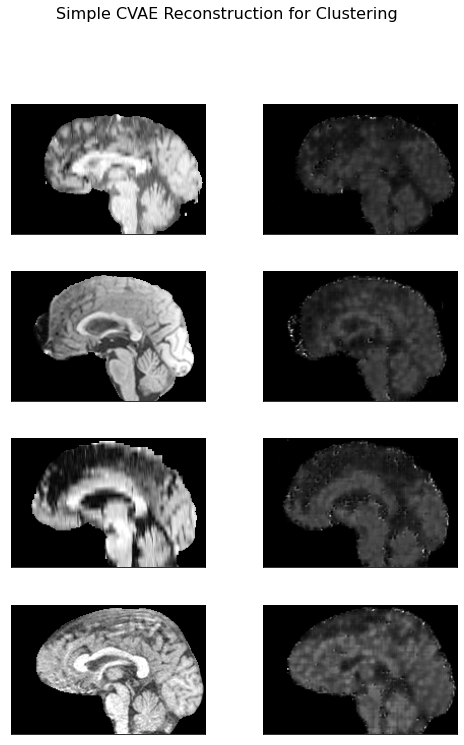

In [106]:
fig, axs = plt.subplots(4,2, figsize=(8,12))
for j in range(4):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    input=dataset[sample_idx][0]
    x_bar, z = model(input[None,:,:,:])
    image_recon = x_bar[0][2].detach().numpy()
    image_recon = np.flip(image_recon, axis = 0)
    image = input[0].detach().numpy()
    image = np.flip(image, axis=0)
    axs[j,1].imshow(image_recon.squeeze(), cmap='gray')
    axs[j,0].imshow(image.squeeze(), cmap='gray')

for ax in axs.flat:
    ax.set_xticks([])  # Remove x-ticks
    ax.set_yticks([])  # Remove y-ticks

fig.suptitle('Simple CVAE Reconstruction for Clustering', fontsize=16)

plt.subplots_adjust(hspace=0.1, wspace=0.3)


In [92]:
data = np.load('/Users/jonat/CSE 547/2Dviz/brain_data_2d.npz')
lst = data.files

x, y = data['x_train'], data['y_train']
data.close()
    
x = x.astype(np.float32)
x = np.transpose(x.data, (0, 1, 3, 2))

clusters = np.load('./clusters.npy')
print(clusters.shape, x.shape)

(2251,) (2251, 4, 128, 192)


In [121]:
keys = list(set(clusters))
cluster_map  = {key: [] for key in keys}

for cluster, scan in zip(clusters, x):
    cluster_map[cluster].append(scan)

for key in keys:
    print(len(cluster_map[key]))

#with open('cluster_map.npz', 'wb') as file:
#    pickle.dump(cluster_map, file)

436
474
313
335
384
309
